[乘用车细分市场销量预测 竞赛 - DataFountain](https://www.datafountain.cn/competitions/352)

本赛题需要参赛队伍根据给出的60款车型在22个细分市场（省份）的销量连续24个月（从2016年1月至2018年12月）的销量数据，建立销量预测模型；基于该模型预测同一款车型和相同细分市场在接下来一个季度连续4个月份的销量；除销量数据外，还提供同时期的用户互联网行为统计数据，包括：各细分市场每个车型名称的互联网搜索量数据等。

简单来说，本次赛题给出2016.1-2017.12的省份，车型，车身，销量，搜索量等数据，要求预测2018.1~2018.4的销量。

评价指标是归一化均方根误差的均值。首先单独计算每个车型在每个细分市场（省份）的NRMSE，再计算所有NRMSE的均值，计算方式为：
![](https://pic3.zhimg.com/80/v2-db586b96b3049267a49888feac1f9e1e_1440w.jpg)

Score为最终评价指标，值为0-1之间，**越接近1模型越准确**。

由于该比赛已经结束，虽然无法提交测试集进行评分，但是在网上可以找到大牛们分享的代码和思想进行学习（在这里感谢大牛们的开源代码，让我受益匪浅）。

鉴于此，本次学习分享采用第21到24个月的数据作为验证集进行评估，评估采用整体预测和分月预测两种方式。

整体预测结果：初赛（60款车型）验证达分数为0.714，复赛（82款车型）验证达分数为0.713。<br>
分月预测结果：初赛（60款车型）验证达分数达0.814，复赛（82款车型）验证达分数达0.806。

In [1]:
import time
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False

import lightgbm as lgb
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import mean_squared_error as MSE

# 一、数据预处理

In [2]:
'*****************************************读取初赛和复赛数据*************************************************'
pre_train_sale = pd.read_csv(r'.\pre_data\train_sales_data.csv') #初赛数据
input_data  = pd.read_csv(r'.\data\train_sales_data.csv') #复赛所有车型数据
final_data  = pd.read_csv(r'.\data\evaluation_public.csv') 
search_data = pd.read_csv(r'.\data\train_search_data.csv')
#将复赛新车型标记出来
pre_model = list(set(list(pre_train_sale['model'])))
input_data['new_model'] = list(map(lambda x: 1 if pre_model.count(x) == 0 else 0,input_data['model']))
final_data['new_model'] = list(map(lambda x: 1 if pre_model.count(x) == 0 else 0,final_data['model']))
def prepare(data):
    #对数据进行预处理，将各个属性转为数值特征
    data['date'] = list(map(lambda x,y:str(x)+"."+str(y),data['regYear'],data['regMonth']))
    data['date'] = pd.to_datetime(data['date'])
    if 'forecastVolum' in list(data.columns):
        data = data.drop(['forecastVolum'],axis=1)
    if 'province' in list(data.columns):
        pro_label = dict(zip(sorted(list(set(data['province']))), range(0, len(set(data['province'])))))
    model_label = dict(zip(sorted(list(set(data['model']))), range(0, len(set(data['model'])))))
    if 'bodyType' in list(data.columns):
        body_label = dict(zip(sorted(list(set(data['bodyType']))), range(0, len(set(data['bodyType'])))))
        data['body_id'] = data['bodyType'].map(body_label)
        data=data.drop(['bodyType'],axis=1)
    if 'province' in list(data.columns):
        data['pro_id'] = data['province'].map(pro_label)
    data['model_id'] = data['model'].map(model_label)
    data=data.drop(['regYear','regMonth','model'],axis=1)
    if 'province' in list(data.columns):
         data=data.drop(['adcode','province'],axis=1)
    data['month_id'] = data['date'].apply(lambda x : x.month)
    data['sales_year'] = data['date'].apply(lambda x : x.year)
    data['time_id'] = list(map(lambda x,y:(x-2016)*12+y,data['sales_year'],data['month_id']))
    data=data.drop(['date'],axis=1).rename(columns={'salesVolume':'label'})
    return data

'*****************************************预处理所有文件*************************************************'
input_data  = prepare(input_data)
final_data  = prepare(final_data)
search_data = prepare(search_data)
#将预测的文件拼接到数据集中并补全bodytype
pivot = pd.pivot_table(input_data,index=['model_id','body_id'])
pivot = pd.DataFrame(pivot).reset_index()[['model_id','body_id']]
final_data = pd.merge(final_data,pivot,on='model_id',how='left')
input_data = pd.merge(input_data,search_data,how='left',on=['pro_id','model_id','sales_year','month_id','time_id'])
input_data = pd.concat([input_data,final_data])
input_data['salesVolume'] = input_data['label']
is_get_82_model,lg,log = 0, 2, 1

# 二、数据分析

**离散数据**<br>
    月份：2016.01-2017.12,预测2018.1-2018.4<br>
    时间：1-28个月<br>
    省份：22个<br>
    车型：初赛60/复赛82<br>
    车身：4种<br>
**连续数据**<br>
    销量：1-15317<br>
    搜索量：25-1552536 <br>
    
**相关分析**<br>
在构造特征之前，对特征进行分析，发现时间特征和销量相关性最强，并绘制各月销量波动变化折线图。

In [3]:
# 离散数据
cate_cols = ['month_id','sales_year','time_id','pro_id','model_id','body_id']
for col in cate_cols:
    print("{} has {} unique values".format(col, input_data[col].nunique()))
    print(input_data[col].value_counts().sort_values(ascending=False))

month_id has 12 unique values
1     5412
2     5412
3     5412
4     5412
5     3608
6     3608
7     3608
8     3608
9     3608
10    3608
11    3608
12    3608
Name: month_id, dtype: int64
sales_year has 3 unique values
2016    21648
2017    21648
2018     7216
Name: sales_year, dtype: int64
time_id has 28 unique values
1     1804
2     1804
3     1804
4     1804
5     1804
6     1804
7     1804
8     1804
9     1804
10    1804
11    1804
12    1804
13    1804
14    1804
15    1804
16    1804
17    1804
18    1804
19    1804
20    1804
21    1804
22    1804
23    1804
24    1804
25    1804
26    1804
27    1804
28    1804
Name: time_id, dtype: int64
pro_id has 22 unique values
0     2296
1     2296
2     2296
3     2296
4     2296
5     2296
6     2296
7     2296
8     2296
9     2296
10    2296
11    2296
12    2296
13    2296
14    2296
15    2296
16    2296
17    2296
18    2296
19    2296
20    2296
21    2296
Name: pro_id, dtype: int64
model_id has 82 unique values
0     616
38 

In [4]:
# 连续数据
num_cols =['salesVolume','popularity']
input_data[num_cols].describe() 

,salesVolume,popularity
count,43296.000000,4.329600e+04
mean,532.833310,1.844380e+04
std,714.993342,5.527716e+04
min,1.000000,2.500000e+01
25%,146.000000,9.250000e+02
50%,308.000000,2.333000e+03
75%,634.000000,1.018575e+04
max,15317.000000,1.552536e+06


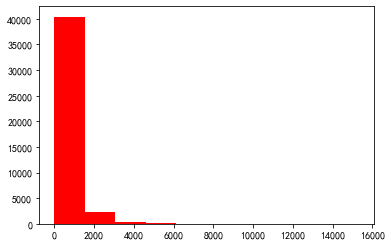

In [5]:
## 预测值的频数
plt.hist(input_data['salesVolume'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show() #直方图，方向，直方图类型

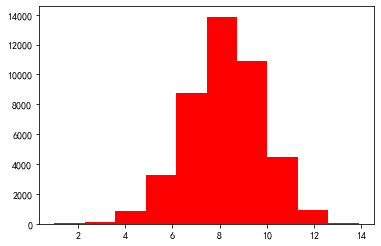

In [6]:
#为了使数据分布更加符合高斯分布，对数据做对数平滑处理。
sale_log=list(map(lambda x : x if x==np.NAN else math.log(x+1,lg),input_data['salesVolume'])) 
plt.hist(sale_log, orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

In [7]:
# 相关性分析
target = input_data[num_cols+cate_cols]
correlation = target.corr()['salesVolume'].sort_values(ascending=False)
correlation

salesVolume    1.000000
month_id       0.107586
body_id        0.077858
popularity     0.050182
time_id        0.020594
pro_id        -0.034343
sales_year    -0.038140
model_id      -0.084913
Name: salesVolume, dtype: float64

In [8]:
# month_id和salesVolume
year_sale=input_data.loc[input_data['sales_year']<2018].groupby(['month_id','sales_year']).agg({'salesVolume': ['sum']}).reset_index()
sale_2016=year_sale.loc[year_sale['sales_year']==2016]['salesVolume']
sale_2017=year_sale.loc[year_sale['sales_year']==2017]['salesVolume']

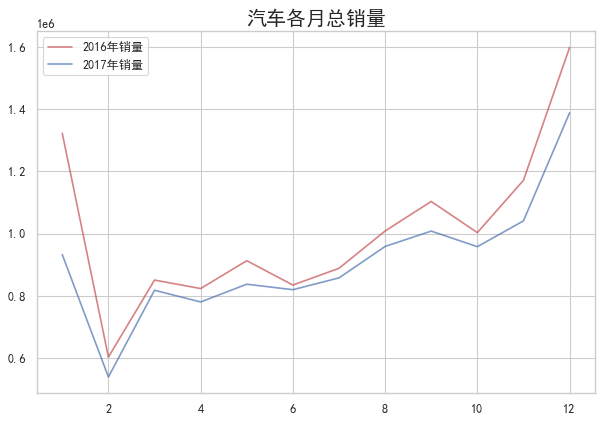

In [25]:
plt.rcParams['font.sans-serif']=['STHeiti'] #正常显示中文 SimHei
plt.rcParams['axes.unicode_minus']=False #正常显示负号
plt.figure(figsize=(9,6),dpi=80)
plt.plot(range(1,13,1),sale_2016,color="r",alpha=0.7,label="2016年销量")
plt.plot(range(1,13,1),sale_2017,color="b",alpha=0.7,label="2017年销量")
plt.legend()
sns.set(style="whitegrid",font="simhei", font_scale=1)
plt.title("汽车各月总销量",fontsize=18)
plt.show()

在构造特征之前，对特征进行分析，发现时间特征和销量相关性最强。<br>

1、整体来看，销量呈周期性变化趋势。2016年与2017年年初的销量都呈下降趋势，到2月春节的销量最低，春节后逐渐上升，12月年末达到最高。<br>
2、2017年的销量较2016年销量整体出现下降趋势,同一时段差异较小。<br>

# 三、特征工程

[CCF BDCI 乘用车销量预测 冠军方案 - 知乎 (zhihu.com)](https://zhuanlan.zhihu.com/p/98926322)

由于是时序问题，历史销量和销量的变化趋势是考虑的重点，可以围绕销量和搜索量在时间和细分市场上的特征进行构建。
因此，构建了历史平移特征，差值特征，同比/环比特征，增量特征与趋势特征。

- 历史月: 历史月销量/搜索量平移,春节月
- 差值'±'： 
    - 前6个相邻/间隔月、前6个月销量统计
    - 细分市场差值：车型/省份/车型-省份前2个月差值
- 环比同比'/'： 
    - 前6个月销量一阶二阶环比
    - 前4月销量同比
    - 前4个月各月份-车型的销量同比
- 趋势特征： 
    - 前4个月和去年同期前2个月的增量
    - 前6个月销量的占比与涨幅：该月销量占月份-省份-车型销量
    - 前6个月搜索量的占比与涨幅：搜索量的环比增长率、该月搜索量占该月份-车型搜索量、该月搜索量占该月份-车身搜索量

In [10]:
def get_stat_feature(df): 
    
    ### 1.历史月特征：历史月和春节月特征
    '''
    历史N月平移特征
    '''
    stat_feat = []
    data = df.copy()
    '历史月销量'
    for i in range(1,17):  
        tmp = data[['time_id','pro_id','model_id','body_id','salesVolume']]
        shifted = tmp.copy()
        shifted = shifted.rename(columns={'salesVolume':'last_{0}_sale'.format(i)})
        shifted['time_id'] += i+2   
        data= pd.merge(data, shifted, on=['time_id','pro_id','model_id','body_id'], how='left')
        if i <= 6:
            stat_feat.append('last_{0}_sale'.format(i)) 
    '历史月popularity'        
    for i in range(1,17): 
        tmp = data[['time_id','pro_id','model_id','body_id','popularity']]
        shifted = tmp.copy()            
        shifted = shifted.rename(columns={'popularity':'last_{0}_popularity'.format(i)})
        shifted['time_id'] += i+2 
        data=pd.merge(data, shifted, on=['time_id','pro_id','model_id','body_id'], how='left')
        if i<=6 or (i>=11 and i<=13):
            stat_feat.append('last_{0}_popularity'.format(i))      
                                   
    '春节月'
    yanhaicity={1,2,5,7,9,13,16,17}
    data['is_yanhai']  = list(map(lambda x:1 if x in yanhaicity else 0,data['pro_id']))
    data['is_chunjie'] = list(map(lambda x:1 if x==2 or x==13 or x==26 else 0,data['time_id']))
    data['is_chunjie_before'] = list(map(lambda x:1 if x==1 or x==12 or x==25 else 0,data['time_id']))
    data['is_chunjie_late']   = list(map(lambda x:1 if x==3 or x==14 or x==27 else 0,data['time_id']))
    month_city_stat_feat = ['is_chunjie','is_chunjie_before','is_chunjie_late','is_yanhai']
    stat_feat = stat_feat + month_city_stat_feat

    '月份'
    count_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    data['count_month'] = list(map(lambda x:count_month[int(x-1)],data['month_id']))
    jiaqibiao = [[11,12,8,10,10,9,10,8,9,13,8,9],[12,9,8,11,10,8,10,8,8,14,8,10],[9,11,9,11]]
    data['count_jiaqi'] = list(map(lambda x,y:jiaqibiao[int(x-2016)][int(y-1)],data['sales_year'],data['month_id']))
    stat_feat.append('count_month')
    stat_feat.append('count_jiaqi')     

    ### 2.销量统计特征：差值、同比环比

    '半年销量等统计特征' 
    data['1_6_sum'] = data.loc[:,'last_1_sale':'last_6_sale'].sum(1)
    data['1_6_mea'] = data.loc[:,'last_1_sale':'last_6_sale'].mean(1) #每个月的平均值
    data['1_6_max'] = data.loc[:,'last_1_sale':'last_6_sale'].max(1)
    data['1_6_min'] = data.loc[:,'last_1_sale':'last_6_sale'].min(1)
    data['jidu_1_3_sum']  = data.loc[:,'last_1_sale':'last_3_sale'].sum(1)
    data['jidu_4_6_sum']  = data.loc[:,'last_4_sale':'last_6_sale'].sum(1)
    data['jidu_1_3_mean'] = data.loc[:,'last_1_sale':'last_3_sale'].mean(1)
    data['jidu_4_6_mean'] = data.loc[:,'last_4_sale':'last_6_sale'].mean(1)
    sales_stat_feat = ['1_6_sum','1_6_mea','1_6_max','1_6_min','jidu_1_3_sum','jidu_4_6_sum','jidu_1_3_mean','jidu_4_6_mean']

    '前6个月相邻月/间隔月销量差值'
    data['1_2_diff'] = data['last_1_sale'] - data['last_2_sale']
    data['1_3_diff'] = data['last_1_sale'] - data['last_3_sale']
    data['2_3_diff'] = data['last_2_sale'] - data['last_3_sale']
    data['2_4_diff'] = data['last_2_sale'] - data['last_4_sale']
    data['3_4_diff'] = data['last_3_sale'] - data['last_4_sale']
    data['3_5_diff'] = data['last_3_sale'] - data['last_5_sale']
    data['jidu_1_2_diff'] = data['jidu_1_3_sum'] - data['jidu_4_6_sum']
    trend_stat_feat = ['1_2_diff','1_3_diff','2_3_diff','2_4_diff','3_4_diff','3_5_diff','jidu_1_2_diff']

    #细分市场前两个月销量差值
    'model 前两个月的销量差值'
    pivot = pd.pivot_table(data,index=['model_id'],values='1_2_diff',aggfunc=np.sum)
    pivot = pd.DataFrame(pivot).rename(columns={'1_2_diff':'model_1_2_diff_sum'}).reset_index()
    data  = pd.merge(data,pivot,on=['model_id'],how='left')
    'pro 前两个月的销量差值'
    pivot = pd.pivot_table(data,index=['pro_id'],values='1_2_diff',aggfunc=np.sum)
    pivot = pd.DataFrame(pivot).rename(columns={'1_2_diff':'pro_1_2_diff_sum'}).reset_index()
    data  = pd.merge(data,pivot,on=['pro_id'],how='left')
    'model,pro 前两个月的销量差值'
    pivot = pd.pivot_table(data,index=['pro_id','model_id'],values='1_2_diff',aggfunc=np.sum)
    pivot = pd.DataFrame(pivot).rename(columns={'1_2_diff':'model_pro_1_2_diff_sum'}).reset_index()
    data  = pd.merge(data,pivot,on=['pro_id','model_id'],how='left')
    pivot = pd.pivot_table(data,index=['pro_id','model_id'],values='1_2_diff',aggfunc=np.mean)
    pivot = pd.DataFrame(pivot).rename(columns={'1_2_diff':'model_pro_1_2_diff_mean'}).reset_index()
    data  = pd.merge(data,pivot,on=['pro_id','model_id'],how='left')
    two_month_stat_feat = ['model_1_2_diff_sum','pro_1_2_diff_sum','model_pro_1_2_diff_sum','model_pro_1_2_diff_mean']
    
    stat_feat = stat_feat + two_month_stat_feat + trend_stat_feat + sales_stat_feat
    
    #环比同比 /
    
    '环比' 
    data = data.copy()
    data['huanbi_1_2'] = data['last_1_sale'] / data['last_2_sale']
    data['huanbi_2_3'] = data['last_2_sale'] / data['last_3_sale']
    data['huanbi_3_4'] = data['last_3_sale'] / data['last_4_sale']
    data['huanbi_4_5'] = data['last_4_sale'] / data['last_5_sale']
    data['huanbi_5_6'] = data['last_5_sale'] / data['last_6_sale']
    ring_ratio_stat_feat = ['huanbi_1_2','huanbi_2_3','huanbi_3_4','huanbi_5_6']
    stat_feat = stat_feat + ring_ratio_stat_feat
    'add环比比'
    data['huanbi_1_2_2_3'] = data['huanbi_1_2'] / data['huanbi_2_3']
    data['huanbi_2_3_3_4'] = data['huanbi_2_3'] / data['huanbi_3_4']
    data['huanbi_3_4_4_5'] = data['huanbi_3_4'] - data['huanbi_4_5'] #？
    data['huanbi_4_5_5_6'] = data['huanbi_4_5'] - data['huanbi_5_6']
    two_ring_ratio_stat_feat = ['huanbi_1_2_2_3','huanbi_2_3_3_4','huanbi_3_4_4_5','huanbi_4_5_5_6']

    '前4月同比' #去年12月各月份-车型销量均值和最小值
    data["increase16_4"]=(data["last_16_sale"] - data["last_4_sale"]) / data["last_16_sale"]
    pivot = pd.pivot_table(data,index=["model_id","time_id"],values='last_12_sale',aggfunc=np.mean)
    pivot = pd.DataFrame(pivot).rename(columns={'last_12_sale':'mean_model'}).reset_index()
    data  = pd.merge(data,pivot,on=["model_id","time_id"],how="left")
    pivot = pd.pivot_table(data,index=["model_id","time_id"],values='last_12_sale',aggfunc=np.min)
    pivot = pd.DataFrame(pivot).rename(columns={'last_12_sale':'min_model'}).reset_index()
    data  = pd.merge(data,pivot,on=["model_id","time_id"],how="left")
    
    '前4个月各月份-车型同比' 
    for i in range(1,5): 
        pivot = pd.pivot_table(data,index=["model_id","time_id"],values='last_{0}_sale'.format(i),aggfunc=np.mean)
        pivot = pd.DataFrame(pivot).rename(columns={'last_{0}_sale'.format(i):'mean_model_{0}'.format(i)}).reset_index()
        data  = pd.merge(data,pivot,on=["model_id","time_id"],how="left")
        #增量特征：在均值上下波动的量
        data['delta_model_sale_{0}'.format(i)] = (data['mean_model_{0}'.format(i)] - data['mean_model']
                                                 ) / data['mean_model']
        stat_feat.append('delta_model_sale_{0}'.format(i))
        pivot = pd.pivot_table(data,index=["model_id","time_id"],values='last_{0}_sale'.format(i+12),aggfunc=np.mean)
        pivot = pd.DataFrame(pivot).rename(columns={'last_{0}_sale'.format(i+12):'mean_model_{0}'.format(i+12)}).reset_index()
        data  = pd.merge(data,pivot,on=["model_id","time_id"],how="left")
        data['delta_model_sale_{0}'.format(i+12)] = (data['mean_model_{0}'.format(i+12)] - data['mean_model']
                                                 ) / data['mean_model']
        if i <= 2:
            stat_feat.append('delta_model_sale_{0}'.format(i+12))
    data["increase_mean_model_14_2"] = (data["mean_model_14"] - data["mean_model_2"]) / data["mean_model_14"]
    data["increase_mean_model_13_1"] = (data["mean_model_13"] - data["mean_model_1"]) / data["mean_model_13"]
    data["increase_mean_model_16_4"] = (data["mean_model_16"] - data["mean_model_4"]) / data["mean_model_16"]
    data["increase_mean_model_15_3"] = (data["mean_model_15"] - data["mean_model_3"]) / data["mean_model_15"]
    data["delta_model_14_2"] = (data["delta_model_sale_14"] - data["delta_model_sale_2"]) / data["delta_model_sale_14"]
    data["delta_model_13_1"] = (data["delta_model_sale_13"] - data["delta_model_sale_1"]) / data["delta_model_sale_3"]
    data["delta_model_16_4"] = (data["delta_model_sale_16"] - data["delta_model_sale_4"]) / data["delta_model_sale_16"]
    data["delta_model_15_3"] = (data["delta_model_sale_15"] - data["delta_model_sale_3"]) / data["delta_model_sale_15"]

    new_stat_feat = ["mean_model","min_model","increase16_4",
                     "increase_mean_model_15_3","increase_mean_model_16_4","increase_mean_model_14_2","increase_mean_model_13_1",
                     'delta_model_14_2',"delta_model_13_1"]
    
    stat_feat = stat_feat + new_stat_feat + two_ring_ratio_stat_feat

    ### 3.趋势特征：销量和搜索量
    
    #前6个月总销量的占比与涨幅
   
    '该月销量占该月份-省份-车型的占比与涨幅'  #data['last_2_sale']/data['pro_body_last_2_sale_sum']
    data = data.copy()
    for i in range(1,7):
        last_time='last_{0}_sale'.format(i)
        pivot = pd.pivot_table(data,index=['time_id','pro_id','body_id'],values=last_time,aggfunc=np.sum)
        pivot = pd.DataFrame(pivot).rename(columns={last_time:'pro_body_last_{0}_sale_sum'.format(i)}).reset_index()
        data  = pd.merge(data,pivot,on=['time_id','pro_id','body_id'],how='left')
        data['last_{0}_sale_ratio_pro_body_last_{0}_sale_sum'.format(i,i)]=list(map(lambda x,y:x/y if y!=0 else 0,data[last_time],data['pro_body_last_{0}_sale_sum'.format(i)]))
        stat_feat.append('last_{0}_sale_ratio_pro_body_last_{0}_sale_sum'.format(i,i))
        if i>=2:
            data['last_{0}_{1}_sale_pro_body_diff'.format(i-1,i)] = data['last_{0}_sale_ratio_pro_body_last_{0}_sale_sum'.format(i-1)]-data['last_{0}_sale_ratio_pro_body_last_{0}_sale_sum'.format(i)]
            stat_feat.append('last_{0}_{1}_sale_pro_body_diff'.format(i-1,i))
    
    '该月销量占该月份-省份的占比与涨幅'
    for i in range(1,7):
        last_time = 'last_{0}_sale'.format(i)
        pivot = pd.pivot_table(data,index=['time_id','pro_id'],values=last_time,aggfunc=np.sum)
        pivot = pd.DataFrame(pivot).rename(columns={last_time:'pro__last_{0}_sale_sum'.format(i)}).reset_index()
        data  = pd.merge(data,pivot,on=['time_id','pro_id'],how='left')
        data['last_{0}_sale_ratio_pro_last_{0}_sale_sum'.format(i,i)]=list(map(lambda x,y:x/y if y!=0 else 0,data[last_time],data['pro__last_{0}_sale_sum'.format(i)]))
        stat_feat.append('last_{0}_sale_ratio_pro_last_{0}_sale_sum'.format(i,i))
        if i>=2:
            data['model_last_{0}_{1}_sale_pro_diff'.format(i-1,i)] = data['last_{0}_sale_ratio_pro_last_{0}_sale_sum'.format(i-1)]-data['last_{0}_sale_ratio_pro_last_{0}_sale_sum'.format(i)]
            stat_feat.append('model_last_{0}_{1}_sale_pro_diff'.format(i-1,i))
    
    #前6个月搜索量的占比与涨幅
    
    '搜索量的环比增长率'
    data = data.copy()
    data['huanbi_1_2popularity'] = (data['last_1_popularity'] - data['last_2_popularity']) / data['last_2_popularity']
    data['huanbi_2_3popularity'] = (data['last_2_popularity'] - data['last_3_popularity']) / data['last_3_popularity']
    data['huanbi_3_4popularity'] = (data['last_3_popularity'] - data['last_4_popularity']) / data['last_4_popularity']
    data['huanbi_4_5popularity'] = (data['last_4_popularity'] - data['last_5_popularity']) / data['last_5_popularity']
    data['huanbi_5_6popularity'] = (data['last_5_popularity'] - data['last_6_popularity']) / data['last_6_popularity']
    popularity_ratio_stat_feat = ['huanbi_1_2popularity','huanbi_2_3popularity','huanbi_3_4popularity','huanbi_4_5popularity','huanbi_5_6popularity']
    stat_feat = stat_feat + popularity_ratio_stat_feat

    '该月搜索量在月份-车型搜索量的占比'
    for i in range(1,7):
        last_time='last_{0}_popularity'.format(i)
        pivot = pd.pivot_table(data,index=['time_id','model_id'],values=last_time,aggfunc=np.sum)
        pivot = pd.DataFrame(pivot).rename(columns={last_time:'model__last_{0}_popularity_sum'.format(i)}).reset_index()
        data  = pd.merge(data,pivot,on=['time_id','model_id'],how='left')
        data['last_{0}_popularity_ratio_model_last_{0}_popularity_sum'.format(i,i)]=list(map(lambda x,y:x/y if y!=0 else 0,data[last_time],data['model__last_{0}_popularity_sum'.format(i)]))
        stat_feat.append('last_{0}_popularity_ratio_model_last_{0}_popularity_sum'.format(i,i))  
    
    '该月搜索量在月份-车身搜索量的涨幅'
    for i in range(1,7):
        last_time='last_{0}_popularity'.format(i)
        pivot = pd.pivot_table(data,index=['time_id','body_id'],values=last_time,aggfunc=np.sum)
        pivot = pd.DataFrame(pivot).rename(columns={last_time:'body_last_{0}_popularity_sum'.format(i)}).reset_index()
        data  = pd.merge(data,pivot,on=['time_id','body_id'],how='left')
        data['last_{0}_popularity_ratio_body_last_{0}_popularity_sum'.format(i,i)]=list(map(lambda x,y:x/y if y!=0 else 0,data[last_time],data['body_last_{0}_popularity_sum'.format(i)]))
        if i>=2:
            data['last_{0}_{1}_popularity_body_diff'.format(i-1,i)] = (data['last_{0}_popularity_ratio_body_last_{0}_popularity_sum'.format(i-1)]-data['last_{0}_popularity_ratio_body_last_{0}_popularity_sum'.format(i)])/data['last_{0}_popularity_ratio_body_last_{0}_popularity_sum'.format(i)]
            stat_feat.append('last_{0}_{1}_popularity_body_diff'.format(i-1,i)) 
            
    return data,stat_feat

## 特征选择

提取出173个特征，通过lightGBM的特征重要性筛选出107个特征。

In [11]:
def LGB(input_data):     
    input_data['salesVolume'] = list(map(lambda x : x if x==np.NAN else math.log(x+1,lg),input_data['salesVolume']))
    input_data['jidu_id'] = ((input_data['month_id']-1)/3+1).map(int)
    data, stat_feat = get_stat_feature(input_data)
    print('all data',data.shape)
    num_feat = ['sales_year']+stat_feat
    cate_feat = ['pro_id','body_id','model_id','month_id','jidu_id']
    features = num_feat + cate_feat
    print('features:',len(features))
    data_xy=data[features+['salesVolume','new_model','id','time_id']]
    print('data_xy:',data_xy.shape)
    print(data_xy.info())
    corr=data_xy[features+['salesVolume']].corr()['salesVolume'].abs().sort_values(ascending=False)
    print(corr.head(15))
    print(corr.tail(15))
    return data_xy

In [12]:
pre_data=input_data.copy()
data_xy = LGB(pre_data)

all data (50512, 173)
features: 107
data_xy: (50512, 111)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50512 entries, 0 to 50511
Columns: 111 entries, sales_year to time_id
dtypes: float64(97), int64(14)
memory usage: 43.2 MB
None
salesVolume                                            1.000000
jidu_1_3_mean                                          0.905277
last_1_sale                                            0.901040
1_6_mea                                                0.900384
last_2_sale                                            0.886450
1_6_min                                                0.877089
1_6_max                                                0.872133
jidu_4_6_mean                                          0.864581
last_3_sale                                            0.863339
last_4_sale                                            0.846517
last_5_sale                                            0.837553
last_6_sale                                            0.834

In [13]:
data_xy.to_csv('data/data_xy.csv',index=False)

In [14]:
data_xy=pd.read_csv('data/data_xy.csv',index_col=False)
data_xy

,sales_year,last_1_sale,last_2_sale,last_3_sale,last_4_sale,last_5_sale,last_6_sale,last_1_popularity,last_2_popularity,last_3_popularity,...,last_5_6_popularity_body_diff,pro_id,body_id,model_id,month_id,jidu_id,salesVolume,new_model,id,time_id
0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,2,20,1,1,8.194757,0,NaN,1
1,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,2,20,1,1,8.867279,0,NaN,1
2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,2,20,1,1,8.011227,0,NaN,1
3,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3,2,20,1,1,8.675957,0,NaN,1
4,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4,2,20,1,1,9.255029,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50507,2018,NaN,8.748193,8.417853,8.159871,7.888743,7.531381,NaN,28455.0,29885.0,...,0.043872,17,3,81,4,2,NaN,1,7300.0,28
50508,2018,NaN,8.169925,6.794416,7.247928,6.658211,6.882643,NaN,24519.0,24425.0,...,-0.007835,18,3,81,4,2,NaN,1,7301.0,28
50509,2018,NaN,8.409391,7.781360,7.409391,7.813781,7.294621,NaN,20130.0,18678.0,...,-0.160143,19,3,81,4,2,NaN,1,7302.0,28
50510,2018,NaN,8.400879,7.912889,7.845490,7.888743,7.707359,NaN,29060.0,29023.0,...,0.144182,20,3,81,4,2,NaN,1,7303.0,28


In [15]:
data_xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50512 entries, 0 to 50511
Columns: 111 entries, sales_year to time_id
dtypes: float64(97), int64(14)
memory usage: 42.8 MB


# 四、模型训练

## 1.评测指标

参考：[2019CCF乘用车销量预测 (qq.com)](https://mp.weixin.qq.com/s/inxMTHiv_J96UKnVR_lmIw)

In [16]:
def score(data):
    pred = data.groupby(['pro_id', 'model_id'])['forecastVolum'].agg(lambda x: list(x))
    label = data.groupby(['pro_id', 'model_id'])['salesVolume'].agg(lambda x: list(x))
    label_mean = data.groupby(['pro_id', 'model_id'])['salesVolume'].agg(lambda x: np.mean(x))
    data_agg = pd.DataFrame()
    data_agg['forecastVolum'] = pred
    data_agg['salesVolume'] = label
    data_agg['label_mean'] = label_mean
    nrmse_score = []
    for raw in data_agg.values:
        nrmse_score.append(MSE(raw[0], raw[1]) ** 0.5 / raw[2])
    return 1 - np.mean(nrmse_score)

## 2.整体预测 0.71

In [17]:
def LGB(input_data,is_get_82_model):
    if is_get_82_model == 0: #如果is_get_82_model == 0，那么选择60model,即input_data['new_model']==0，否则用全部数据，即82model
        input_data = input_data[input_data['new_model']==0]
    # 数据集划分
    df = input_data.copy()
    cate_feat = ['pro_id','body_id','model_id','month_id','jidu_id']
    for i in cate_feat:
        df[i] = df[i].astype('category')
    features = [col for col in list(df.columns) if col not in ['salesVolume','new_model','id','time_id','forecastVolum']]
    print('features:',len(features))
    train_idx = df['time_id']<= 20 #1-20
    valid_idx = df['time_id'].between(21, 24) 
    test_idx  = df['time_id']> 24 #25-28
    train_x = df[train_idx][features]
    train_y = df[train_idx]['salesVolume']
    valid_x = df[valid_idx][features]
    valid_y = df[valid_idx]['salesVolume']
    x_test = df[test_idx][features]
    
    #初始化model    
    model = lgb.LGBMRegressor(
                num_leaves=2**5-1, reg_alpha=0.55, reg_lambda=0.6, objective='mse',
                max_depth=-1, learning_rate=0.05, min_child_samples=20, random_state=2021,
                n_estimators=700, subsample=0.8, colsample_bytree=0.8 )
    # 验证
    model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],categorical_feature=cate_feat,verbose=100)
    df['forecastVolum'] = model.predict(df[features])
    df['forecastVolum'] = list(map(lambda x : x if x==np.NAN else (lg**(x))-1, df['forecastVolum']))
    df['salesVolume'] = list(map(lambda x : x if x==np.NAN else (lg**(x))-1, df['salesVolume']))
    print('NRMSE的均值:',score(data = df[valid_idx]))
    sub_cv=df[valid_idx][['salesVolume','forecastVolum']]
    
    # 预测测试集1-4月
    df = input_data.copy()
    model.fit(df[~test_idx][features], df[~test_idx]['salesVolume'], categorical_feature=cate_feat) 
    df['forecastVolum'] = model.predict(df[features])
    df['forecastVolum'] = list(map(lambda x : x if x==np.NAN else (lg**(x))-1, df['forecastVolum'])) 
    sub = df[test_idx][['id']]
    sub['forecastVolum'] = df[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    feat_df = pd.DataFrame({'feature': model.booster_.feature_name(), 
                'importance':model.feature_importances_}).sort_values(by=['importance'],ascending=False)      
    return sub, sub_cv, feat_df

In [18]:
if __name__=="__main__":
    input_data=data_xy.copy()
    print('train lgb model...')
    print('use 60 models to train lgb model...')
    sub_60,sub_cv_60,feat_df_60=LGB(input_data,0)
    print('use 82 models to train lgb model...')
    sub_82,sub_cv_82,feat_df_82=LGB(input_data,1)

train lgb model...
use 60 models to train lgb model...
features: 107
[100]	valid_0's l2: 0.324608
[200]	valid_0's l2: 0.315845
[300]	valid_0's l2: 0.318831
[400]	valid_0's l2: 0.321913
[500]	valid_0's l2: 0.32373
[600]	valid_0's l2: 0.324633
[700]	valid_0's l2: 0.324867
NRMSE的均值: 0.7145146260046289
use 82 models to train lgb model...
features: 107
[100]	valid_0's l2: 0.282853
[200]	valid_0's l2: 0.268934
[300]	valid_0's l2: 0.269041
[400]	valid_0's l2: 0.270845
[500]	valid_0's l2: 0.272733
[600]	valid_0's l2: 0.273308
[700]	valid_0's l2: 0.274118
NRMSE的均值: 0.7137188478138556


In [19]:
print(sub_82,sub_cv_82)
print(feat_df_82.head(15))
print(feat_df_82.tail(15))

           id  forecastVolum
43296     1.0            312
43297     2.0            350
43298     3.0            165
43299     4.0            301
43300     5.0            435
...       ...            ...
50507  7300.0            132
50508  7301.0            111
50509  7302.0             98
50510  7303.0            124
50511  7304.0             50

[7216 rows x 2 columns]        salesVolume  forecastVolum
26400        308.0     272.226393
26401        306.0     304.936089
26402        176.0     181.264874
26403        293.0     384.372827
26404        449.0     379.643406
...            ...            ...
43271         60.0      51.693463
43292         74.0      59.906751
43293         48.0      47.767251
43294         48.0      69.077800
43295         57.0      78.389457

[7216 rows x 2 columns]
                                               feature  importance
104                                           model_id        4119
102                                             pro_id      

## 3.分月预测 0.8

In [20]:
def LGB(input_data,is_get_82_model):
    if is_get_82_model == 0: 
        input_data = input_data[input_data['new_model']==0]
    # 提取特征
    df = input_data.copy()
    cate_feat = ['pro_id','body_id','model_id','month_id','jidu_id']
    for i in cate_feat:
        df[i] = df[i].astype('category')
    features = [col for col in list(df.columns) if col not in ['salesVolume','new_model','id','time_id','forecastVolum']]
    print('features:',len(features))
    
    # 1 划分数据集，验证
    for month in [21,22,23,24]: 
        train_idx = df['time_id'].between(1 , month-1) #20-23 
        valid_idx = df['time_id'].between(month, month) #21-24 首先得到21月份的结果，然后将21月份合并到训练集，预测22月份结果，然后是23月，24月。
        train_x = df[train_idx][features]
        train_y = df[train_idx]['salesVolume']
        valid_x = df[valid_idx][features]
        valid_y = df[valid_idx]['salesVolume']
        model = lgb.LGBMRegressor(
                num_leaves=2**5-1, reg_alpha=0.55, reg_lambda=0.6, objective='mse',
                max_depth=-1, learning_rate=0.05, min_child_samples=20, random_state=2021,
                n_estimators=700, subsample=0.8, colsample_bytree=0.8 )
        model.fit(df[train_idx][features], df[train_idx]['salesVolume'],eval_set=[(valid_x, valid_y)], 
                  categorical_feature=cate_feat,verbose=100) #注意缩进，含month的语句要在for这个循环里，可以实现分月预测
        df['forecastVolum'] = model.predict(df[features])
        df.loc[(df.time_id==month),  'forecastVolum'] = df[valid_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x)
    df['forecastVolum'] = list(map(lambda x : x if x==np.NAN else (lg**(x))-1, df['forecastVolum']))
    df['salesVolume'] = list(map(lambda x : x if x==np.NAN else (lg**(x))-1, df['salesVolume']))
    print('NRMSE的均值:',score(data = df[df.time_id.between(21, 24)]))
    sub_cv=df[df.time_id.between(21, 24)][['salesVolume','forecastVolum']]
    
    # 2 预测测试集1-4月
    df = input_data.copy() 
    for month in [25,26,27,28]: 
        all_idx   = df['time_id'].between(1 , month-1)
        test_idx  = df['time_id'].between(month, month) #25-28 首先得到1月份的结果，然后将1月份合并到训练集，预测2月份结果，然后是3月，4月。
        model.fit(df[all_idx][features], df[all_idx]['salesVolume'], categorical_feature=cate_feat)
        df['forecastVolum'] = model.predict(df[features])
        df.loc[(df.time_id==month),  'salesVolume'] = df[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x)
    df['salesVolume'] = list(map(lambda x : x if x==np.NAN else (lg**(x))-1, df['salesVolume'])) 
    sub = df[df.time_id > 24][['id','salesVolume']]
    sub.columns = ['id','forecastVolum']
    sub['id'] = sub['id'].map(int)
    sub['forecastVolum'] = sub['forecastVolum'].map(round)
    return sub_cv,sub

In [22]:
if __name__=="__main__":
    input_data=data_xy.copy()
    print('train lgb model...')
    print('use 60 models to train lgb model...')
    sub_cv60,sub_60=LGB(input_data,0)
    print('use 82 models to train lgb model...')
    sub_cv82,sub_82 =LGB(input_data,1)

train lgb model...
use 60 models to train lgb model...
features: 107
[100]	valid_0's l2: 0.168596
[200]	valid_0's l2: 0.163125
[300]	valid_0's l2: 0.162815
[400]	valid_0's l2: 0.16158
[500]	valid_0's l2: 0.161241
[600]	valid_0's l2: 0.160976
[700]	valid_0's l2: 0.161653
[100]	valid_0's l2: 0.270008
[200]	valid_0's l2: 0.248915
[300]	valid_0's l2: 0.24319
[400]	valid_0's l2: 0.241997
[500]	valid_0's l2: 0.239627
[600]	valid_0's l2: 0.237863
[700]	valid_0's l2: 0.235363
[100]	valid_0's l2: 0.144645
[200]	valid_0's l2: 0.127899
[300]	valid_0's l2: 0.126423
[400]	valid_0's l2: 0.124397
[500]	valid_0's l2: 0.125324
[600]	valid_0's l2: 0.124724
[700]	valid_0's l2: 0.124875
[100]	valid_0's l2: 0.348148
[200]	valid_0's l2: 0.302176
[300]	valid_0's l2: 0.297648
[400]	valid_0's l2: 0.293041
[500]	valid_0's l2: 0.293665
[600]	valid_0's l2: 0.293066
[700]	valid_0's l2: 0.293063
NRMSE的均值: 0.8144276487236164
use 82 models to train lgb model...
features: 107
[100]	valid_0's l2: 0.161493
[200]	valid_0

In [23]:
sub_cv82,sub_82

(       salesVolume  forecastVolum
 26400        308.0     286.069508
 26401        306.0     303.850280
 26402        176.0     175.883707
 26403        293.0     329.557608
 26404        449.0     411.231827
 ...            ...            ...
 43271         60.0      50.694576
 43292         74.0      66.914160
 43293         48.0      49.476354
 43294         48.0      60.136256
 43295         57.0      74.906163
 
 [7216 rows x 2 columns],
          id  forecastVolum
 43296     1            312
 43297     2            350
 43298     3            165
 43299     4            301
 43300     5            435
 ...     ...            ...
 50507  7300            129
 50508  7301             85
 50509  7302             95
 50510  7303            132
 50511  7304             43
 
 [7216 rows x 2 columns])

In [24]:
print('save final result...')
sub_60.to_csv('Result/sub_60.csv',index=False)
sub_82.to_csv('Result/sub_82.csv',index=False)

save final result...
